In [1]:
# %matplotlib qt

In [2]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import sys 
import mne

In [3]:
# constants
freq_bands = { 
    'beta1' : (12, 18),
    'beta2' : (18, 24),
    'beta3' : (24, 30),
    'gamma1' :(30, 36),
    'gamma2' :(36, 42),
    'gammaH' :(70, 150)
}
sampling_freq = 1000
scaling_f = 0.0298
save_path = os.path.join(os.getcwd(),'processed_data')

In [4]:
# Data load Function
def load_data(subject, data_pth):
    
    # this function takes a subject id and a data path. It finds the mne_Info, mne_Imag, and mne_Overt data for the given subject.
    # input: subject id (str)
    # return: mne_Info (mne Info object), mne_Imag, mne_Overt (mne object)
    
    imag = loadmat(os.path.join(data_pth,'{}_im_t_h.mat'.format(subject)))
    overt = loadmat(os.path.join(data_pth,'{}_mot_t_h.mat'.format(subject)))
    n_channels = imag['data'].shape[1]
    mne_Info, mne_Imag ,mne_Overt, stim_events =mne_conv(imag, overt, sampling_freq, scaling_f, n_channels)

    return mne_Info, mne_Imag, mne_Overt, stim_events


def mne_conv(imag, overt, sampling_freq, scaling_f, n_channels):
    # Creating Info MNE Object
    mne_Info= mne.create_info(n_channels, sampling_freq)#, ch_types=['ecog']*n_channels)

    # Notch Filtering 
    filtered_data_Imag = []
    filtered_data_Overt = []
    for i in range(n_channels):
        channel_Imagdata = imag['data'][:,i] * scaling_f
        channel_Overtdata = overt['data'][:,i] * scaling_f

        filtered_Imag = mne.filter.notch_filter(channel_Imagdata, sampling_freq, np.arange(60,241,60))
        filtered_Overt = mne.filter.notch_filter(channel_Overtdata, sampling_freq, np.arange(60,241,60))

        filtered_data_Imag.append(filtered_Imag)
        filtered_data_Overt.append(filtered_Overt)

    # Creating MNE objects 
    mne_Overt = mne.io.RawArray(filtered_data_Overt, mne_Info)
    mne_Imag = mne.io.RawArray(filtered_data_Imag, mne_Info)
    
    # Create stimulation events and add them to the respective mne objects
    stim_events_overt = np.array([np.array([i, 0, stim[0]]) for i, stim in enumerate(overt['stim']) if overt['stim'][i-1]<stim]) # Stimulations
    stim_events_imag = np.array([np.array([i, 0, stim[0]]) for i, stim in enumerate(imag['stim']) if imag['stim'][i-1]<stim]) # Stimulations
    for ch in mne_Overt.ch_names:
        mne_Overt.add_events(stim_events_overt, stim_channel = ch)
        mne_Imag.add_events(stim_events_imag, stim_channel = ch)
    
    return mne_Info, mne_Imag, mne_Overt, stim_events_overt

def filter_frequency_bands(mne_Imag, mne_Overt, freq_limit, picks=[]):
    if len(picks)==0:
        picks = mne_Overt.ch_names
    freq_mne_Overt = mne_Overt.copy().filter(freq_limit[0], freq_limit[1], picks=picks).pick(picks)
    freq_mne_Imag = mne_Imag.copy().filter(freq_limit[0], freq_limit[1], picks=picks).pick(picks)
    return freq_mne_Overt, freq_mne_Imag

def bandpass_hilbert_epochs (picks, mne_Imag, mne_Overt):
    
    # This function applies bandpass filters and hilbert transform to given imagery and overt data. Bandpass filters are applied
    # to every channel, whereas hilbert transform is only applied to the 'picks' (simulated channels). It then finds the respective
    # epochs of the hand & tongue events for both imaginary and overt data.
    
    # input: picks (a list of int), mne_Imag, and mne_Overt (both are mne objects)
    # return: hilbert_overt, hilbert_imag, hand_epochs_overt/imag, tongue_epochs_overt/imag
        # all are dictionaries of hilbert-transformed/epoches data for every bands of overt/imaginary data
        # e.g. hilbert_overt ['beta1'] returns the hilbert-transformed beta1 waves for overt movement.
    
    hilbert_overt = {}
    hilbert_imag = {}
    
    hand_epochs_overt = {}
    hand_epochs_imag = {}
    
    tongue_epochs_overt = {}
    tongue_epochs_imag = {}

    for band in freq_bands:
        
        freq_mne_Overt, freq_mne_Imag = filter_frequency_bands(mne_Imag, mne_Overt, freq_bands[band])
        hilbert_freq_mne_Overt = freq_mne_Overt.copy().apply_hilbert(picks = picks, envelope=True)
        hilbert_freq_mne_Imag = freq_mne_Imag.copy().apply_hilbert(picks = picks, envelope=True)
        
        hilbert_overt [band] = hilbert_freq_mne_Overt
        hilbert_imag [band] = hilbert_freq_mne_Imag
        
        hand_epochs_Img = get_epochs_data(hilbert_freq_mne_Imag.copy(), '12')
        hand_epochs_imag [band] = hand_epochs_Img
        
        hand_epochs_Overt = get_epochs_data(hilbert_freq_mne_Overt.copy(), '12')
        hand_epochs_overt [band] = hand_epochs_Overt

        tng_epochs_Img = get_epochs_data(hilbert_freq_mne_Imag.copy(), '11')
        tongue_epochs_imag [band] = tng_epochs_Img
        
        tng_epochs_Overt = get_epochs_data(hilbert_freq_mne_Overt.copy(), '11')
        tongue_epochs_overt [band] = tng_epochs_Overt
        
    return hilbert_overt, hilbert_imag, hand_epochs_overt, hand_epochs_imag, tongue_epochs_overt, tongue_epochs_imag

def get_epochs_data(hilbert_freq_mne, event_id):
    epochs_mne_data = mne.Epochs(hilbert_freq_mne.copy(), events = stim_events, tmin=-1, tmax=3)[event_id]
    return epochs_mne_data


def save_epoches (hand_ima, hand_overt, tng_ima, tng_overt, save_path): 
    np.save(os.path.join(save_path,'hand_Epochs_Img_{}.npy'.format(band)),np.array(hand_ima._get_data()))
    np.save(os.path.join(save_path,'hand_Epochs_Overt_{}.npy'.format(band)),np.array(hand_overt._get_data()))
    np.save(os.path.join(save_path,'Tng_Epochs_Overt_{}.npy'.format(band)),np.array(tng_ima._get_data()))
    np.save(os.path.join(save_path,'Tng_Epochs_Img_{}.npy'.format(band)),np.array(tng_overt._get_data()))
    print('saved '+band)
    


In [5]:

# Example: preprocess the data for subject jc
picks = [19, 20, 21, 26, 27, 28, 35, 36]
picks_str = [str(i) for i in picks]

mne_Info, mne_Imag, mne_Overt, stim_events = load_data ('jc','sourcedata/imagery_basic/data')
hilbert_overt, hilbert_imag, hand_epochs_overt, hand_epochs_imag, tng_epochs_overt, tng_epochs_imag = bandpass_hilbert_epochs (picks, mne_Imag, mne_Overt) 

hilbert_overt

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband att

- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop fi

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
--

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Setting

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 24 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 24.00
- Lower transition bandwidth: 6.00 Hz (-6 dB cutoff frequency: 21.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 551 samples (0.551 sec)

Not setting metadata
60 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
60 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
60 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline co

{'beta1': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'beta2': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'beta3': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'gamma1': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'gamma2': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'gammaH': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>}

In [6]:
hilbert_overt

{'beta1': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'beta2': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'beta3': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'gamma1': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'gamma2': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'gammaH': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>}

Using matplotlib as 2D backend.
Opening raw-browser...


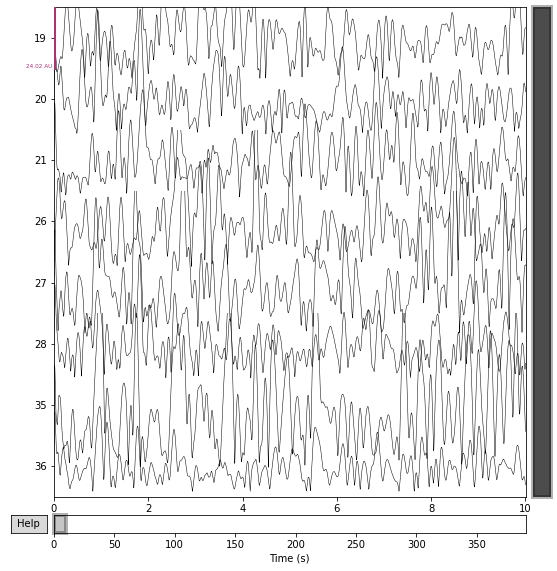

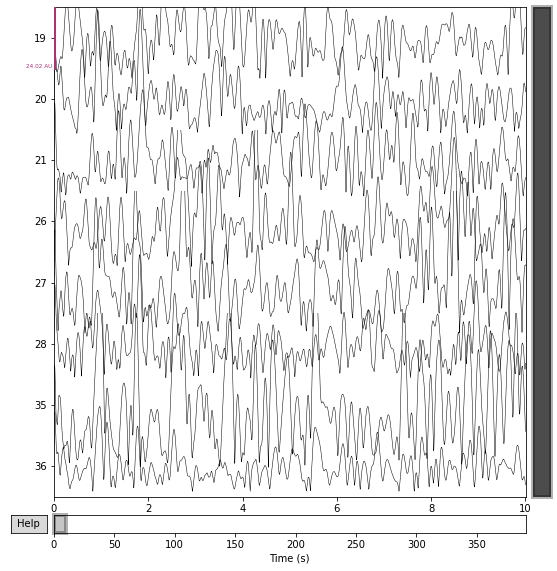

In [7]:
beta1_overt = hilbert_overt ['beta1']
beta2_imag = hilbert_imag ['beta2']
gammaH_imag = hilbert_overt ['gammaH']

#plotting the above data
#beta1_overt.pick_channels(picks_str).plot()
beta2_imag.pick_channels (picks_str).plot()
#gammaH_imag.pick_channels(picks_str).plot()

In [8]:
# example of how the epochs data looks like.
hand_epochs_overt

{'beta1': <Epochs |  30 events (good & bad), -1 - 3 sec, baseline -1 – 0 sec, ~50 kB, data not loaded,
  '12': 30>,
 'beta2': <Epochs |  30 events (good & bad), -1 - 3 sec, baseline -1 – 0 sec, ~50 kB, data not loaded,
  '12': 30>,
 'beta3': <Epochs |  30 events (good & bad), -1 - 3 sec, baseline -1 – 0 sec, ~50 kB, data not loaded,
  '12': 30>,
 'gamma1': <Epochs |  30 events (good & bad), -1 - 3 sec, baseline -1 – 0 sec, ~50 kB, data not loaded,
  '12': 30>,
 'gamma2': <Epochs |  30 events (good & bad), -1 - 3 sec, baseline -1 – 0 sec, ~50 kB, data not loaded,
  '12': 30>,
 'gammaH': <Epochs |  30 events (good & bad), -1 - 3 sec, baseline -1 – 0 sec, ~50 kB, data not loaded,
  '12': 30>}

In [9]:
# similar for hilbert-transformed data.
hilbert_overt

{'beta1': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'beta2': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'beta3': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'gamma1': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'gamma2': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>,
 'gammaH': <RawArray | 48 x 390720 (390.7 s), ~143.1 MB, data loaded>}

In [36]:
#plots of the simulated channels after hilbert transform
#hilbert_freq_mne_Imag.pick_channels(picks_str).plot()

In [37]:
# use the average of all channels as reference
# Img_avg_ref = mne_Imag.copy().set_eeg_reference(ref_channels='average')
# Overt_avg_ref = mne_Overt.copy().set_eeg_reference(ref_channels='average')
# Img_avg_ref.plot()

In [66]:
tng_epochs_imag['beta1']._get_data()

Using data from preloaded Raw for 30 events and 4001 original time points ...
0 bad epochs dropped


array([[[-4.14011828e+00, -7.16523269e+00, -1.00585049e+01, ...,
         -2.82129321e+00, -4.57123237e+00, -6.29955253e+00],
        [-1.79203523e+01, -1.96346592e+01, -2.12094554e+01, ...,
         -4.58191083e+00, -3.60609031e+00, -2.67424967e+00],
        [-5.00600034e+00, -6.69414334e+00, -8.32500005e+00, ...,
         -5.52965085e+00, -4.80571395e+00, -4.05924902e+00],
        ...,
        [ 1.51005509e+01,  1.45549342e+01,  1.39017123e+01, ...,
         -7.76549718e+00, -8.31375364e+00, -8.79336535e+00],
        [ 1.39585162e+01,  1.31920173e+01,  1.23234175e+01, ...,
         -7.32250942e+00, -7.71581743e+00, -8.04915851e+00],
        [ 1.33525423e+01,  1.25896608e+01,  1.17266878e+01, ...,
         -7.33520906e+00, -7.67916587e+00, -7.96410825e+00]],

       [[ 3.88859913e+01,  3.89931003e+01,  3.88928106e+01, ...,
         -1.51869365e+01, -1.40115769e+01, -1.27108972e+01],
        [ 2.58591457e+01,  2.62022147e+01,  2.63041280e+01, ...,
         -6.50779785e+00, -6.51026288e

In [67]:
(tng_epochs_imag['beta1']._get_data()==tng_epochs_overt['beta1']._get_data())

Using data from preloaded Raw for 30 events and 4001 original time points ...
Using data from preloaded Raw for 30 events and 4001 original time points ...
0 bad epochs dropped


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

## Apply models

1. Train test split 
2. Takes input, output(optional), model ->e.g, Kmeans, RandomForest, SVM
3. Evaluation 
    -> Confusion (TPR, FPR)
    -> Tree based-> feature importance
    -> ROC-AUC
    


In [150]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [26]:
processed_data, labels = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
        processed_data, labels, random_state=42, test_size=0.2)
n_train_samples = len(X_train)
n_test_samples = len(X_test)
n_features = X_train.shape[1]

In [34]:
def build_fit_model(X_train, y_train=None, model='kmeans', **kwargs):
    if model=='kmeans':
        kmeans_model = KMeans(**kwargs)
        kmeans_model.fit(X_train)
        return kmeans_model
    elif model=='gmm':
        gmm_model = GaussianMixture( **kwargs)
        gmm_model.fit(X_train)
        return gmm_model
    elif model=='lr':
        clf_model = LogisticRegression(**kwargs)
        clf_model.fit(X_train, y_train)
        return clf_model
    elif model=='svm':
        clf_model = SVC(**args)
        clf_model.fit(X_train, y_train)
        return lr_model
    elif model=='random_forest':
        clf_model = RandomForestClassifier(**kwargs)
        clf_model.fit(X_train, y_train)
        return clf_model
    elif model=='decision_tree':
        clf_model = DecisionTreeClassifier(**kwargs)
        clf_model.fit(X_train, y_train)
        return clf_model

In [20]:
model

KMeans(n_clusters=2)

In [23]:
X_train.shape

(80, 20)

In [119]:
global n_components
global n_clusters
global n_classes
global truth, n_samples

def create_arguments(dataset_type = 'test', n_cls=2):
    n_components=n_clusters=n_classes=n_cls
    if dataset_type=='train':
        truth, n_samples = train_truth, n_train_samples 
    else:
        truth, n_samples = test_truth, n_test_samples  

## Clustering Evaluation

In [132]:
# Prep
model_name='gmm'
create_arguments('train', n_cls=2)

if model_name=='gmm':
    model = build_fit_model(X_train, model=model_name, n_components=n_components)
else:
    model = build_fit_model(X_train, model=model_name, n_clusters=n_clusters)

labels = model.predict(X_train)
labels_matched = np.empty_like(labels)


# creating mapping between cluster labels and actual labels
test_truth = np.empty(n_test_samples)
train_truth = np.empty(n_train_samples)

data  = np.empty((n_samples, n_features))
np.random.seed(42)

for i,mu in enumerate(np.random.choice([0,1], n_samples, replace=True)):
    truth[i]  = mu
    data[i,:] = np.random.normal(loc=mu, scale=1.5, size=n_features)

# For each cluster label...
for k in np.unique(labels):

    # ...find and assign the best-matching truth label
    match_nums = [np.sum((labels==k)*(truth==t)) for t in np.unique(truth)]
    labels_matched[labels==k] = np.unique(truth)[np.argmax(match_nums)]

In [133]:
# labels

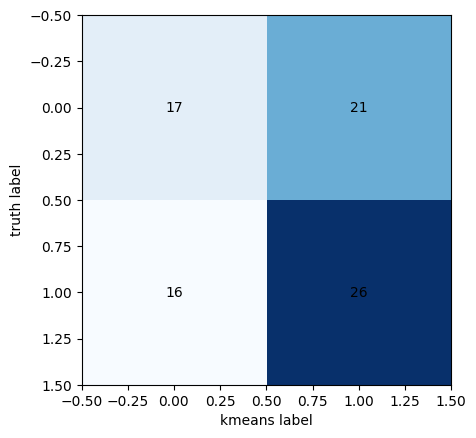

In [134]:
# Compute confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth, labels_matched)

# Plot confusion matrix
plt.imshow(cm,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()

## Classification Evaluation

In [135]:
model_name = 'random_forest'
classifier = build_fit_model(X_train, y_train, model=model_name)


In [136]:
# x_pred_score

### Confusion Matrix

/Users/lavanyamk/Virtual_Envs/common_python3_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


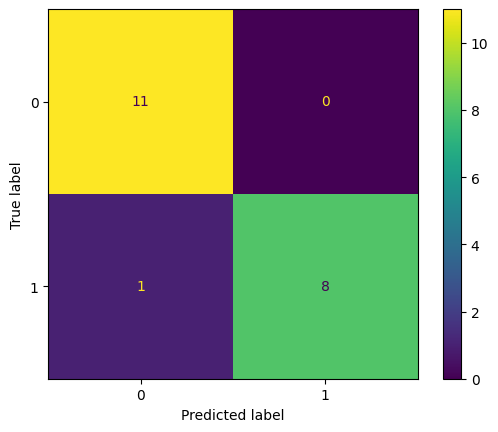

In [137]:
plot_confusion_matrix(classifier, X_test, y_test)  
plt.show()

### Feature importance

In [138]:
features= [str(i) for i in range(processed_data.shape[1])]

<BarContainer object of 20 artists>

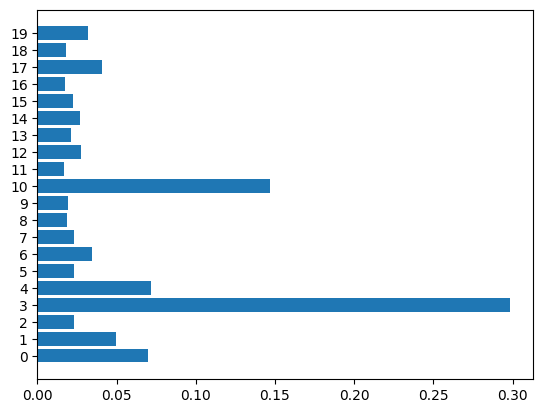

In [139]:
plt.barh(features, classifier.feature_importances_)

### ROC AUC curve

In [147]:
len(y_train)

80

/Users/lavanyamk/Virtual_Envs/common_python3_venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


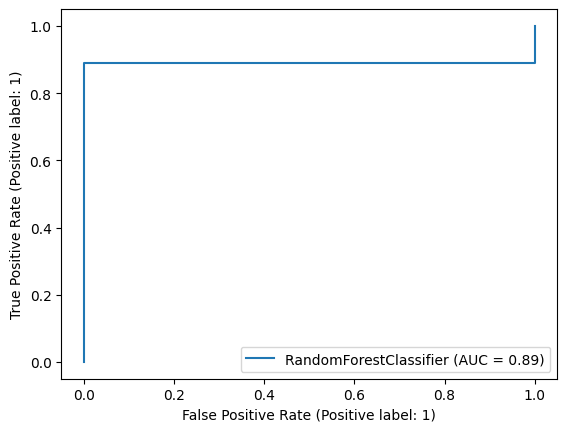

In [151]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

metrics.plot_roc_curve(classifier, X_test, y_test) 

plt.show()